# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [ ]:
!pip install networkx==2.3

In [ ]:
!pip install stellargraph

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [ ]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [ ]:
edges = [tuple(x) for x in data.values.tolist()]

In [ ]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [ ]:
A = list(nx.connected_component_subgraphs(B))[0]

In [ ]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


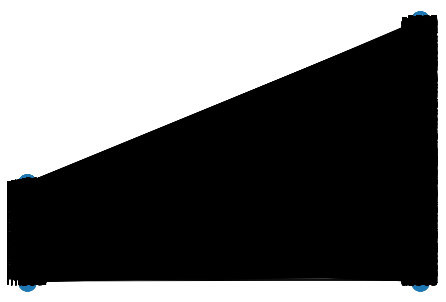

In [ ]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [ ]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


Hence there are 1292 Movie Nodes and 3411 Actor Nodes in the Data. It shows that one Actor may have taken part in many movies.

In [ ]:

# Create the random walker to Generate Embeddings for All movies and actor nodes
#We first need to generate Random Walks for each node in the Graph. A random walk is where the algorithm explores the nodes in the graph and then using W2V, we embed the nodes into size 128 Dimensional Vectors
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [ ]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality (4703*128)
node_targets = [ A.node[node_id]['label'] for node_id in node_ids] #List of Targets #Whether a node in the Graph belongs to 'actors' or 'movies'

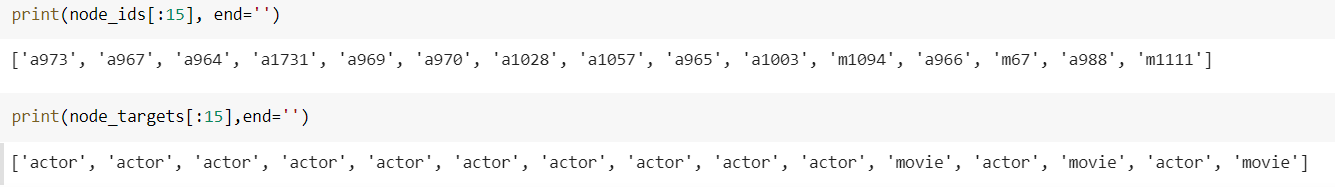

In [ ]:
def data_split(node_ids,node_targets,node_embeddings): #We already have a arrays of node_ids, node_embeddings, node_targets. We just have to split the node_embeddings array into their node_targets
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes

    actor_id_index= [ind for ind,node_ids in enumerate(node_ids) if 'a' in node_ids] #indices of actors in node_ids list
    movie_id_index= [ind for ind,node_ids in enumerate(node_ids) if 'm' in node_ids] #indices of movies in node_ids list

    actor_nodes=[node_ids[i] for i in actor_id_index] #List of Actor nodes
    movie_nodes=[node_ids[j] for j in movie_id_index] #List of Movie Nodes
    
    movie_embeddings = node_embeddings[movie_id_index,:]
    actor_embeddings = node_embeddings[actor_id_index,:]
    
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings

actor_nodes, movie_nodes,actor_embeddings,movie_embeddings= data_split(node_ids,node_targets,node_embeddings)


<font color='cyan'>Grader function - 1</font>

In [ ]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [ ]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

#METRICS

1. **Cost1**

Cost1 is Maximum for a Cluster if the largest connected component of the SubGraph is the whole SubGraph itself.
It means that all the Actors/Movies of the SubGraph are strongly inter-related (actors having acted in same/similar movies).

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

According to the above formula for Cost1, the maximum value that Cost1 can take is 1.(If the largest connected component of each SubGraph of the clusters is the whole SubGraph itself).

In [ ]:
def cost_1(graph,number_of_clusters):
    '''In this function, we will calculate Cost1'''
    #Calculate Cost1 
    cc= sorted(nx.connected_components(graph),key=len,reverse=True) #Gets all the connected components in the whole Graph and sorts in descending order based on number of nodes in the connected components (list of lists)
    largest_cc= graph.subgraph(cc[0]) #SubGraph view of the largest connected component
    c= len(largest_cc.nodes)/len(graph.nodes) #Number of Nodes in the largest CC of the cluster/ Total Number of Nodes in that cluster.
    cost1= c/number_of_clusters #Formula of Cost 1 as above
    
    return cost1

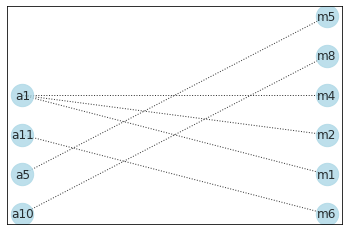

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [ ]:
graded_cost1=cost_1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

2. Cost2

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

Cost2 for Actor Nodes is Maximum if each actor has acted in every movie present in the Graph.

In [ ]:
def cost_2(graph,number_of_clusters):
    '''In this function, we will calculate cost2'''
    actor_deg_list= list(graph.degree(actor_nodes))
    S_a=0
    for i in actor_deg_list:
      S_a=S_a+i[1]
    unique_movies= len([i for i in graph.nodes if 'm' in i])
    cost_act= S_a/unique_movies
    cost2= cost_act/number_of_clusters

    return cost2

<font color='cyan'>Grader function - 4</font>

In [ ]:
graded_cost2=cost_2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

# COST Calculation:

Cost= Cost1*Cost2.

Maximum most Cost is obtained when all actors have acted in Similar/Same movies and each actor has acted in every movie. In this situation, possible the best cluster is 1 (the whole graph itself)

Higher the Cost, more is the similarity between each actor and each movie.

<font color='blue'>Grouping similar actors</font>

We will Define a Function to get the Best Number of Clusters for 'Actors/Movies' based on Maximum Value of the **Cost** Metric using '**KMeans Clustering**' Algorithm.

In [ ]:

def best_cluster_nodes(num_of_clusters_list,nodes,node_embeddings,edge_list):
  """ 
  This Function will return the Best Cluster which is Max(Cost1*Cost2) for each cluster using KMeans Algorith
  """
  Cost_list_for_each_cluster_number=[] #Total Cost for each 'number of clusters' in 'num_of_clusters_list'.
  for c in num_of_clusters_list:
    clustering_model= KMeans(n_clusters=c,init='k-means++',max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    clustering_model.fit(node_embeddings) #Fits the Actor/Movie Embeddings in K-Means and returns the cluster number to which each Actor/Movie belongs
    
    #Now we need to create Subgraphs for each cluster
    labels= clustering_model.labels_ #ndarray of shape (n_samples)(For Ex: If number of clusters=3, it returns [0,1,2,1,2,1,2,2,2,1,0,0](Cluster Number to which each Actor/Movie Belongs to))
    L=sorted(list(set(labels))) #List of Set of Unique Cluster Labels ([For Ex: If number of clusters=3, unique cluster labels= [0,1,2] in ascenting order ])
    #Get Node IDs for each cluster
    node_ids_cluster_list= [(nodes[i],labels[i]) for i in range(len(nodes))] #Like (a123,2) where a123=Actor Node, 2= Cluster Label to which it belongs to
    Cluster_List=[] #Initiate Empty list to append 'List of Nodes of each Cluster i' [[a123,124,a55,a97,a305,a454],[a15,a1,a2,a77],[a99,a567,a450,a1000],...]
    #Each List inside Cluster_List contains the Actor Nodes which belong to the corresponding Cluster Number in list L.
    for n in L:
      cluster_members=[] #Member nodes of Each Cluster
      for i in (node_ids_cluster_list):
        if i[1]==n:
          cluster_members.append(i[0])
      Cluster_List.append(cluster_members) #Like [[a123,124,a55,a97,a305,a454],[a15,a1,a2,a77],[a99,a567,a450,a1000],...]
  
      
    Cost_1_list,Cost_2_list=[],[] #To Append Cost1 and Cost2 for each Cluster in Cluster_List
    for i in Cluster_List: #For each cluster in cluster list
      sub_graph_edges=[] #To append existing edges for SubGraphs of Each Cluster
      for j in i: #For each node in i
        for k in edges: #For each edge in Edges List
          if j in k: #If j exists in an edge (Ex: a12 is present in edge (m10,a12))
            sub_graph_edges.append(k) #[Sub_graph= [(m10,a12),]
      act= np.unique([actors for i in sub_graph_edges for actors in i if 'a' in actors]) #List of Unique Actors in the SubGraph
      movies= np.unique([mov for j in sub_graph_edges for mov in j if 'm' in mov]) #List of Unique Movies in the SubGraph
    
      #Create SubGraph using above 'act' and 'movies' nodes list and 'sub_graph_edges' list.
      sub_G=nx.Graph()
      sub_G.add_nodes_from(act,bipartite=0,label='Actors')
      sub_G.add_nodes_from(movies, bipartite=1, label='Movies')
      sub_G.add_edges_from(sub_graph_edges,label='Acted')
    
      C1= cost_1(sub_G,c) #Cost1 is calculated for each individual cluster by calling 'cost_1' function from above.
      Cost_1_list.append(C1) #Cost1 is appended to Cost_1_list.
    
      C2= cost_2(sub_G,c) #Cost2 is calculated for each individual cluster by calling 'cost_2' function from above.
      Cost_2_list.append(C2) #Cost2 is appended to Cost_2_list.
    
    Cost1=sum(Cost_1_list) #Cost1 for each cluster is summed.
    Cost2=sum(Cost_2_list) #Cost2 for each cluster is summed
    
    Cost=Cost1*Cost2 #Cost is calculated for all the CLusters as Cost=Cost1*Cost2

    Cost_list_for_each_cluster_number.append(Cost) 

  # Return a Dictionary wit Key:Value = Number of CLuster: Cost
  d= {num_of_clusters_list[i]:Cost_list_for_each_cluster_number[i] for i in range(len(num_of_clusters_list))}
  print("Cost for each Number of Clusters (Number Of Clusters: Cost=Cost1*Cost2):{}".format(d))
  max_value= max(d,key= lambda x: d[x])
  print("Number of Clusters having Maximum Cost:")
  return max_value



### Best Cluster for Actor Nodes

In [ ]:
#Obtaining the Best Cluster Number having Maximum Cost=Cost1*Cost2 for Actor Nodes
BC_actors= best_cluster_nodes(num_of_clusters_list=[3,5,10,30,50,100,200,500],nodes=actor_nodes,node_embeddings=actor_embeddings, edge_list=edges)
BC_actors

Cost for each Number of Clusters (Number Of Clusters: Cost=Cost1*Cost2):{3: 3.7139743351179244, 5: 2.8649636420065963, 10: 2.314686149714321, 30: 1.6814923543447318, 50: 1.6123735732977529, 100: 1.516778971015837, 200: 1.6643145451702366, 500: 1.7918391080313725}
Number of Clusters having Maximum Cost:


3

Hence, after computing the Cost Metric for each Number of Clusters, we see that the Number of Clusters having the highest Cost Value= **3 Clusters**

Hence we shall fit the Actor Embeddings with **KMeans** having **Number of Clusters=3**

In [ ]:
Best_Cluster_Actors= KMeans(n_clusters=int(BC_actors),init='k-means++',max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(actor_embeddings)
Labels= Best_Cluster_Actors.labels_
print(Labels)

[1 1 1 ... 2 2 2]


<font color='blue'>Displaying similar actor clusters</font>

Here we will convert Actor Embeddings of Size (3411,128) into 2-Dimensions (3411,2) for Visualisation of Clusters (Similar Actors Grouped).

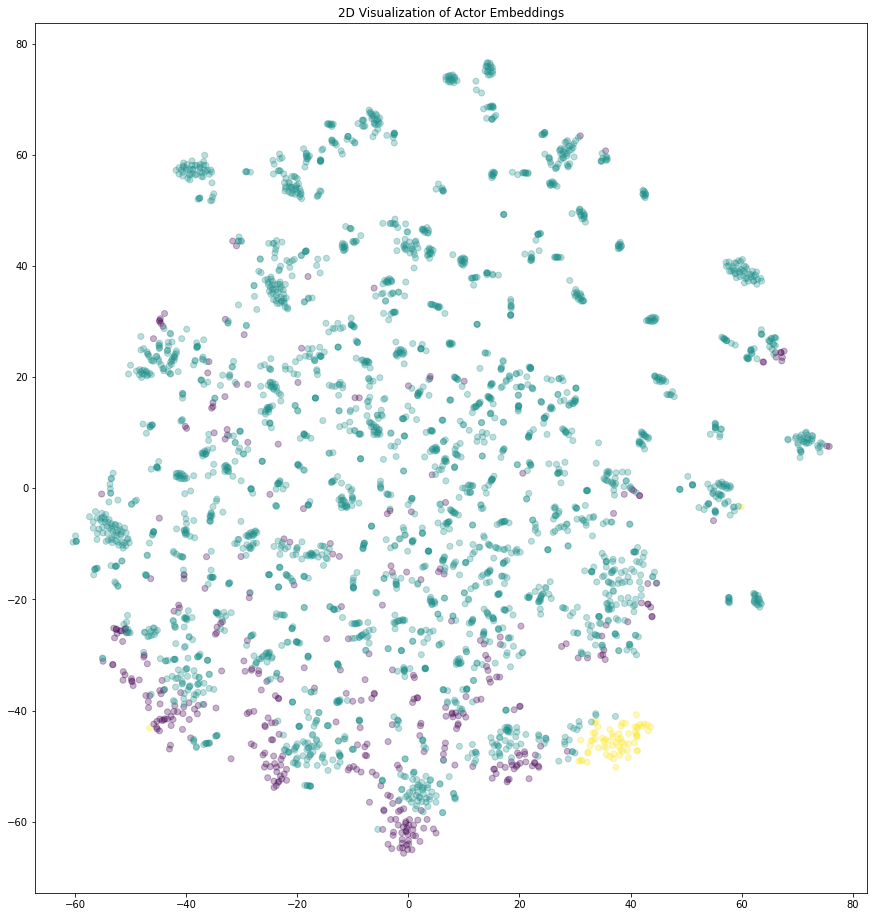

In [ ]:
from sklearn.manifold import TSNE
transform= TSNE
trans= transform(n_components=2)

actor_embeddings_2d= trans.fit_transform(actor_embeddings)

import numpy as np
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(actor_embeddings_2d[:,0], 
            actor_embeddings_2d[:,1], 
            c=Labels, alpha=0.3)
plt.title('2D Visualization of Actor Embeddings'.format(transform.__name__))

plt.show()

In the above TSNE Visualisation of Actors, each color represents a similar group of Actors.

<font color='blue'>Grouping similar movies</font>

Here we need to change the Definition of Cost2 as per Movie Nodes.

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 

In [ ]:
def cost_2(graph,number_of_clusters):
    '''In this function, we will calculate cost2'''
    movie_deg_list= list(graph.degree(movie_nodes))
    S_m=0
    for i in movie_deg_list:
      S_m=S_m+i[1]
    unique_actors= len([i for i in graph.nodes if 'a' in i])
    cost_mov= S_m/unique_actors
    cost2= cost_mov/number_of_clusters

    return cost2

### Best Cluster for Movie Nodes

In [ ]:
#Obtaining the Best Cluster Number having Maximum Cost=Cost1*Cost2 for Movie Nodes
BC_movies= best_cluster_nodes(num_of_clusters_list=[3,5,10,30,50,100,200,500],nodes=movie_nodes,node_embeddings=movie_embeddings, edge_list=edges)
BC_movies

Cost for each Number of Clusters (Number Of Clusters: Cost=Cost1*Cost2):{3: 2.835488351550839, 5: 2.5749000872080963, 10: 2.563866858240678, 30: 2.0181832874537196, 50: 1.856189990162665, 100: 1.5268814462380567, 200: 1.3655414479263086, 500: 1.2006114619665373}
Number of Clusters having Maximum Cost:


3

Hence, after computing the Cost Metric for each Number of Clusters, we see that the Number of Clusters having the highest Cost Value= **3 Clusters**

Hence we shall fit the Movie Embeddings with **KMeans** having **Number of Clusters=3**

In [ ]:
Best_Cluster_Movies= KMeans(n_clusters=int(BC_movies),init='k-means++',max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(movie_embeddings)
Labels= Best_Cluster_Movies.labels_

<font color='blue'>Displaying similar movie clusters</font>

Here we will convert Movie Embeddings of Size (1292,128) into 2-Dimensions (1292,2) for Visualisation of Clusters (Similar Movies Grouped).

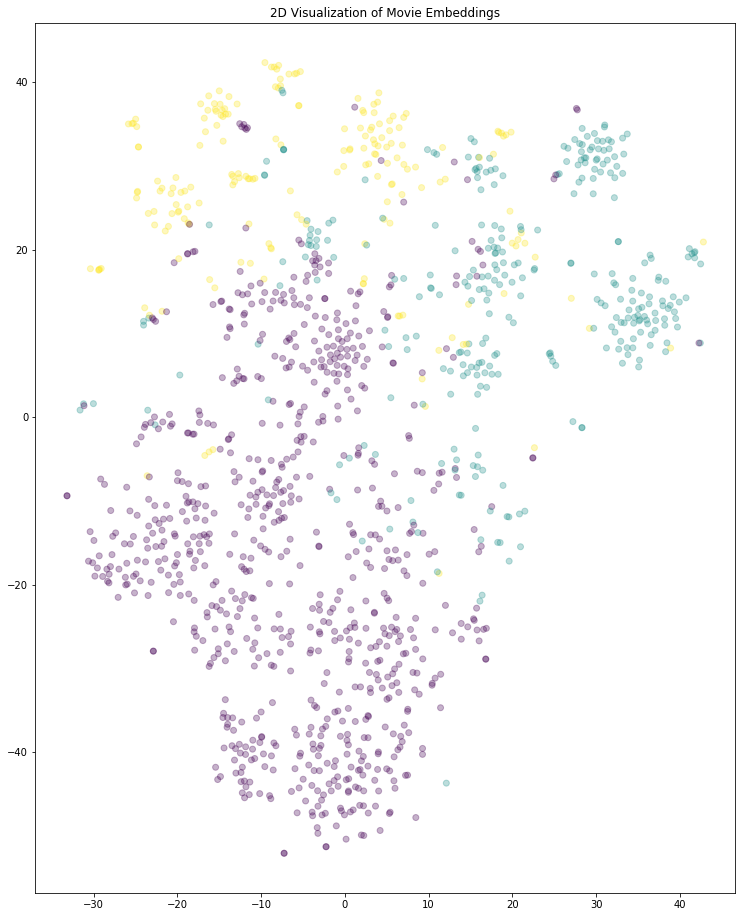

In [ ]:
movie_embeddings_2d= trans.fit_transform(movie_embeddings)
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(movie_embeddings_2d[:,0], 
            movie_embeddings_2d[:,1], 
            c=Labels, alpha=0.3)
plt.title('2D Visualization of Movie Embeddings'.format(transform.__name__))

plt.show()

Each color represents movie nodes belonging to the same Cluster

# CONCLUSION

* I have used **KMeans Clustering** to group Similar Actors and Similar Movies in the movies_actors Graph Dataset (Bipartite Graph) using the metric **Cost** (defined above).

* Each of the Actor/Movie nodes were converted into 128 Dimension vector Embeddings using W2V and later visualised in 2D using TSNE where each color represented vectors belonging to a certain cluster.

* **Cost**

1. Best Number of Clusters for Actor Nodes= **3** (having highest Cost= 3.71)
2. Best Number of Clusters for Movie Nodes= **3** (having highest Cost=2.83)


